# <center> CS677 - Fall2025 : Machine Learning
# <center> Assignment 3
## <center> Professor: Dr. Krishna Bathula
### <center> By: Ran Roffe, Kiara Jamal, Stanely Occean

# Question 1

## Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please refer to
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`. See
`sphx_glr_auto_examples_ensemble_plot_hgbt_regression.py` for an example
showcasing some other advantages of
:class:`~ensemble.HistGradientBoostingRegressor`.


In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import parse_version

### Load the data

In [3]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

### Data preprocessing

Next, we will split our dataset to use 90% for training and leave the rest
for testing. We will also set the regression model parameters. You can play
with these parameters to see how the results change.

`n_estimators` : the number of boosting stages that will be performed.
Later, we will plot deviance against boosting iterations.

`max_depth` : limits the number of nodes in the tree.
The best value depends on the interaction of the input variables.

`min_samples_split` : the minimum number of samples required to split an
internal node.

`learning_rate` : how much the contribution of each tree will shrink.

`loss` : loss function to optimize. The least squares function is  used in
this case however, there are many other options (see
:class:`~sklearn.ensemble.GradientBoostingRegressor` ).



In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)

param_grid = {
    "n_estimators": [10, 100, 500],
    "max_depth": [1, 3, 5],
    "min_samples_split": [2, 5, 10],
    "learning_rate": [0.001, 0.01, 0.1],
    "loss": ["squared_error"]
    
}


## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [9]:
# Grid-search style training: iterate over all combinations in `param_grid` and fit models.
from itertools import product

param_names = ["n_estimators", "max_depth", "min_samples_split", "learning_rate", "loss"]
grid_values = [param_grid[name] for name in param_names]
models = []
results = []

for vals in product(*grid_values):
    p = dict(zip(param_names, vals))
    reg = ensemble.GradientBoostingRegressor(**p)
    reg.fit(X_train, y_train)
    mse = mean_squared_error(y_test, reg.predict(X_test))
    models.append(reg)
    results.append({"params": p, "mse": mse, "train_score": reg.train_score_})
    print(f"Trained: {p}, MSE: {mse:.4f}")

Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 2, 'learning_rate': 0.001, 'loss': 'squared_error'}, MSE: 5370.5755
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'squared_error'}, MSE: 5138.8247
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 2, 'learning_rate': 0.1, 'loss': 'squared_error'}, MSE: 3876.7260
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 5, 'learning_rate': 0.001, 'loss': 'squared_error'}, MSE: 5370.5755
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 5, 'learning_rate': 0.01, 'loss': 'squared_error'}, MSE: 5138.8247
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 5, 'learning_rate': 0.1, 'loss': 'squared_error'}, MSE: 3876.7260
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_split': 10, 'learning_rate': 0.001, 'loss': 'squared_error'}, MSE: 5370.5755
Trained: {'n_estimators': 10, 'max_depth': 1, 'min_samples_s

## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



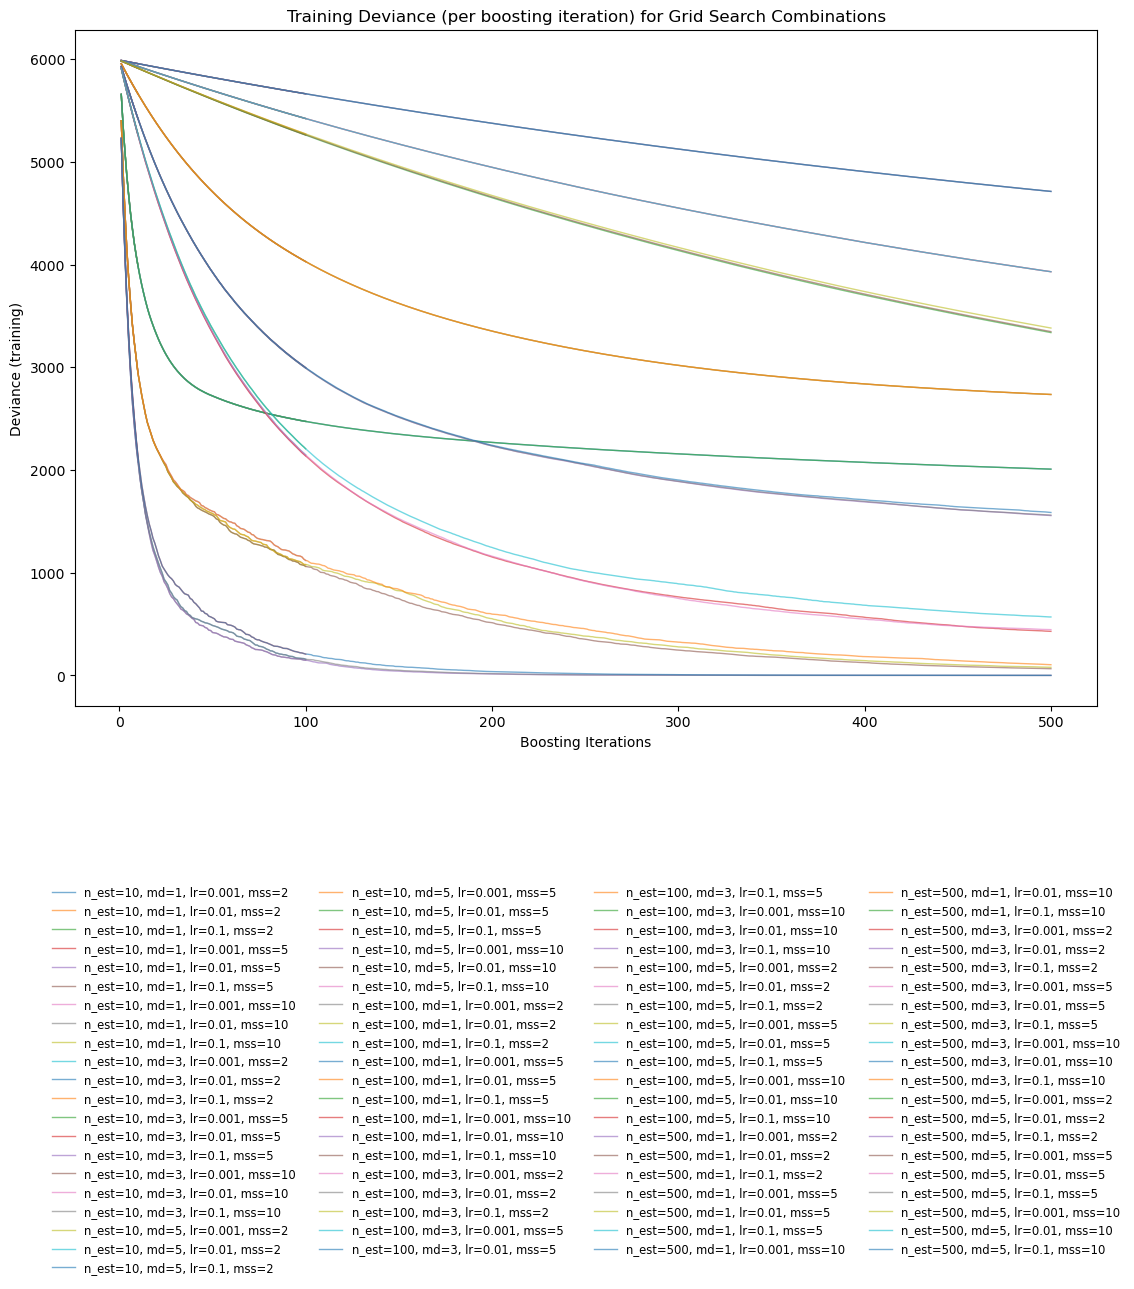

In [13]:
# Plot training deviance for every grid combination.
fig = plt.figure(figsize=(12, 14))
plt.title("Training Deviance (per boosting iteration) for Grid Search Combinations")

# Plot each model's training deviance curve. There may be many lines; use alpha and small fontsize.
for res in results:
    train_score = res["train_score"]
    n = len(train_score)
    p = res["params"]
    label = (
        f"n_est={p['n_estimators']}, md={p['max_depth']}, lr={p['learning_rate']}, "
        f"mss={p['min_samples_split']}"
    )
    plt.plot(np.arange(n) + 1, train_score, '-', alpha=0.6, linewidth=1, label=label)

plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance (training)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize='small', frameon=False)

fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



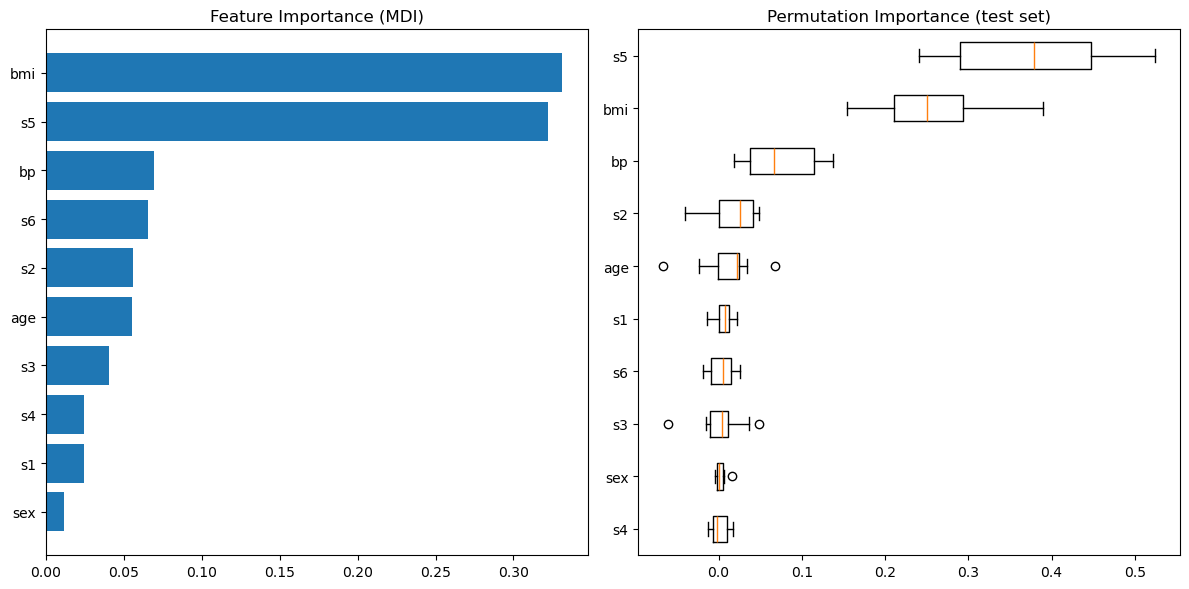

In [7]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
tick_labels_dict = {
    tick_labels_parameter_name: np.array(diabetes.feature_names)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Question 2

## 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## 2. Load dataset and create DataFrame

In [ ]:
# load dataset and create DataFrame
iris = load_iris(as_frame=True)        # convenient to get pandas frame
df = iris.frame.copy()                 # includes features and target
df.rename(columns={"target": "species"}, inplace=True)
df["species"] = df["species"].map(dict(enumerate(iris.target_names)))

print("First 5 rows:")
print(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  
Shape: (150, 5)
Columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']


This preview shows the first five samples in the Iris dataset. Each row has the flower’s sepal and petal measurements along with its species. The dataset has 150 rows and 5 columns, so everything loaded correctly. This quick check helps us get familiar with the data before doing deeper analysis.


## 3. Basic info, Data Types and Summary Statistic

In [ ]:
print("Info:")
print(df.info())

print("Summary statistics for numeric features:")
print(df.describe())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
Summary statistics for numeric features:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
7

All columns have 150 valid values, so there are no missing data. The summary stats show the averages and ranges for each flower measurement, helping us quickly see how the features vary. Overall, the dataset is clean and ready for analysis.


## 4. Data Cleaning & Missing Values Hnalding

### 4.1 Check missing values

In [ ]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64


All columns show zero missing values. This means the dataset is already complete and doesn’t require any cleaning for missing data. We can safely move on to the next steps.

### 4.2 Check for duplicate rows

In [ ]:
print("Number of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

Number of duplicate rows: 1
Shape after dropping duplicates: (149, 5)


There was 1 duplicate row, so after removing it the dataset now has 149 rows. This helps keep the data clean and avoids repeated samples.


## 5. Univariate Analysis: Distributions and Outliers

In [ ]:
numeric_cols = [col for col in df.columns if col.isnumeric()]

### Histograms / KDE plots
Histograms and KDE plots are used to visualize the distribution of each feature. By looking at the distributions, we can see how the features vary across the different species and how they compare to each other. From the plots, we can also detect outliers and understand how the features are spread out. This information can help choose the best features for our model, as features that are normally distributed are easier to model, while the other ones need to be transformed and treated.

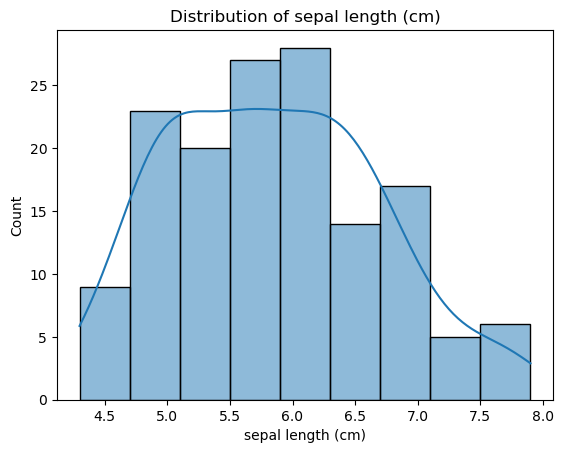

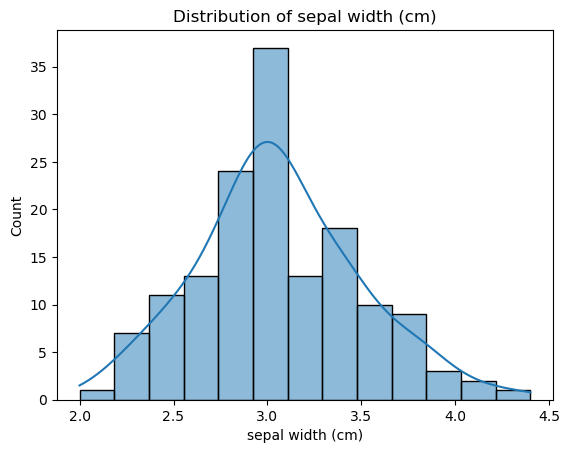

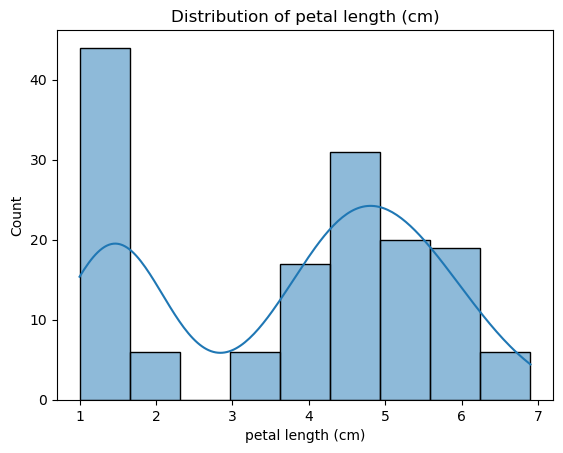

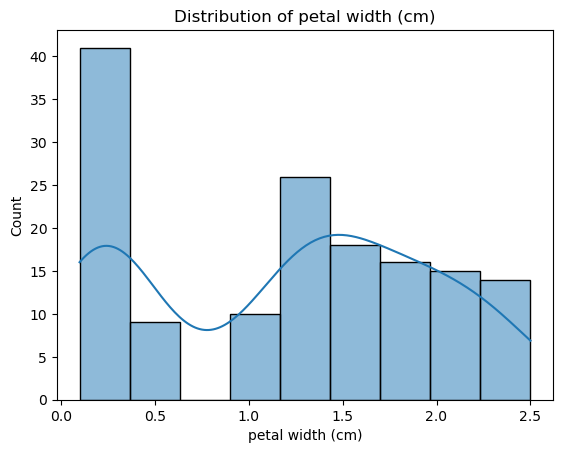

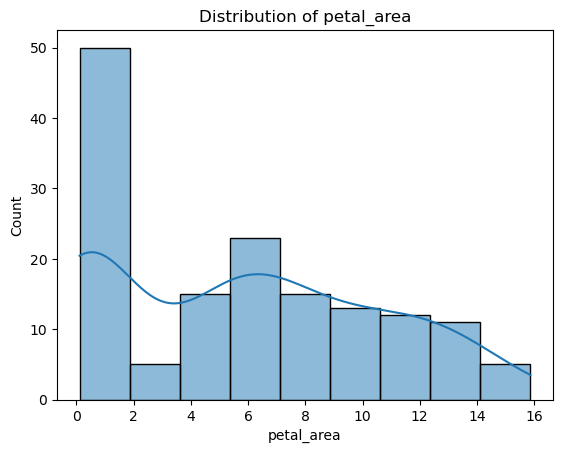

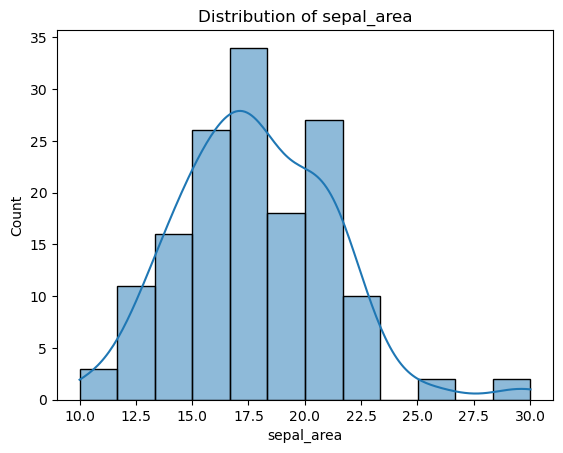

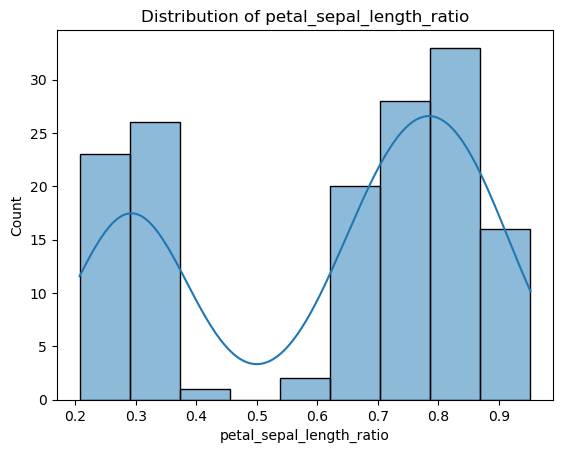

In [ ]:
numeric_cols = [col for col in df.columns if col != "species"]

for col in numeric_cols:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Sepal Length
This shows a fairly spread-out distribution, meaning sepal length varies a lot across flowers.
Sepal Width
This looks more centered, showing most flowers have a similar sepal width.
Petal Length
This plot has clear groups, showing big differences between species.
Petal Width
Like petal length, this also shows grouped patterns, meaning petal width strongly separates species.

### Boxplots for outliers
Outliers are data points that fall outside the range of the rest of the data. In order to detect outliers, we use boxplots, which show the following:

- The minimum and maximum values
- The first and third quartiles
- The median

By looking at the boxplots, we can see which columns have outliers and how strong the outliers are.

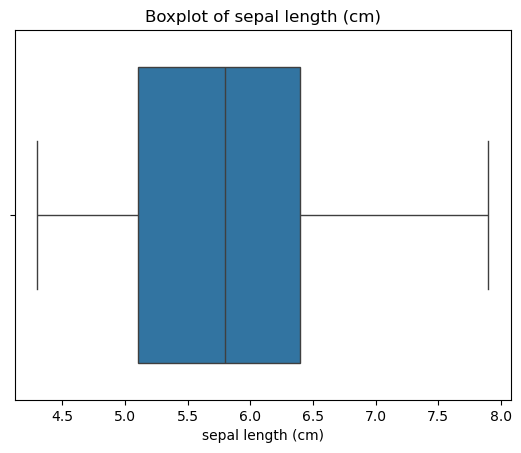

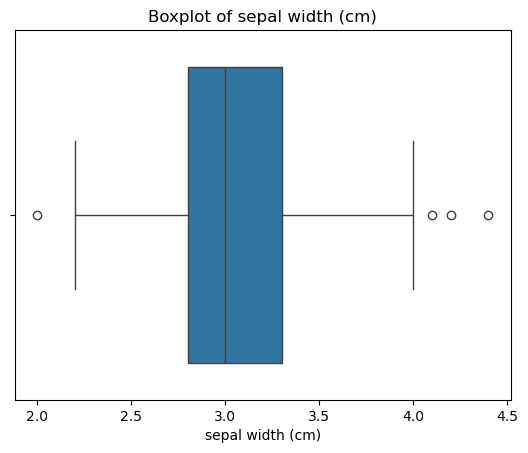

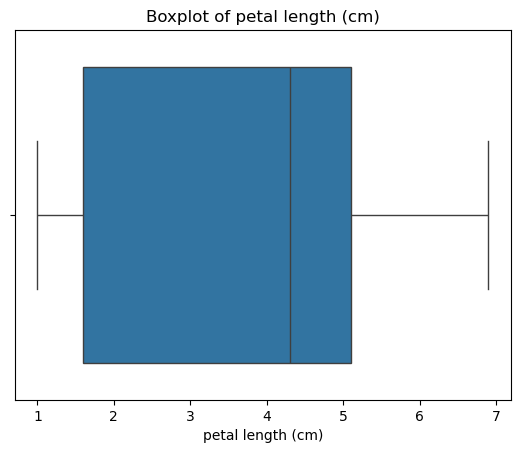

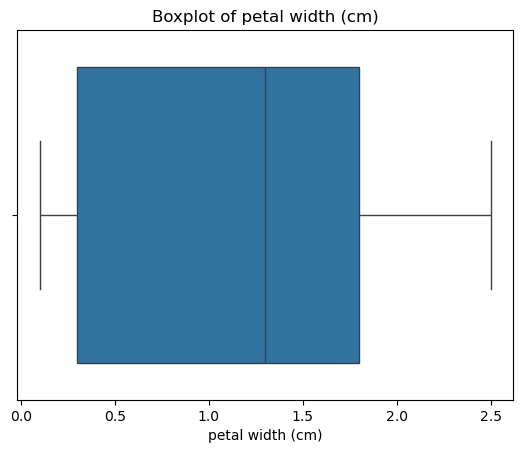

In [ ]:
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

- For `Sepal Length`, we can see that it has a fairly even spread with no major outliers. Also, a few outliers appear on both sides, meaning some flowers have unusually narrow or wide sepals.

- For `Petal Length`, we can view that the wide range shows strong variation across species, reflecting clear differences between species.

- `Petal Width` is similar to petal length, and the wide range shows strong variation across species aswell.

### Boxplots by species

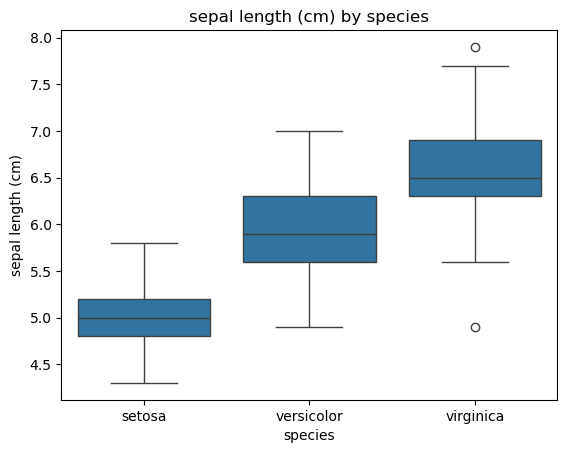

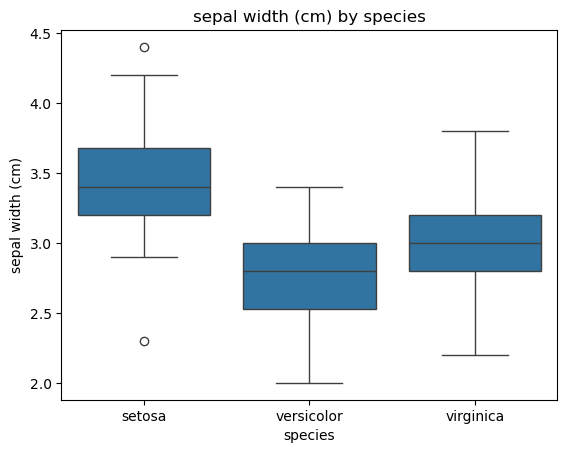

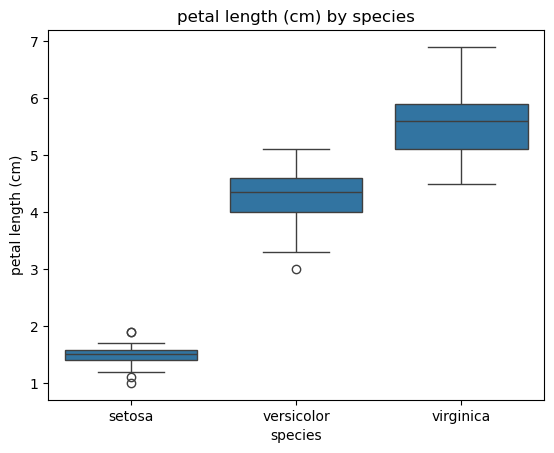

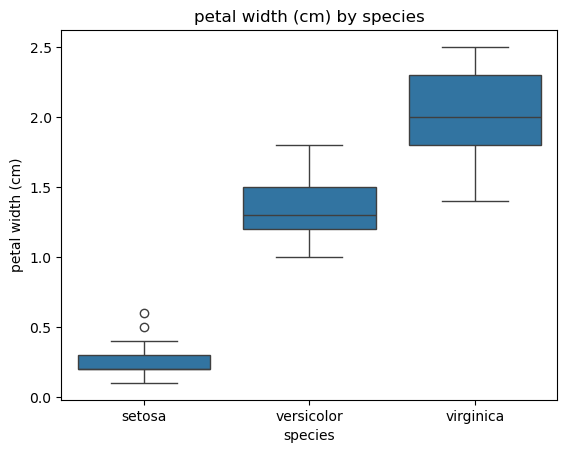

In [ ]:
for col in numeric_cols:
    sns.boxplot(x="species", y=col, data=df)
    plt.title(f"{col} by species")
    plt.show()

By looking at the boxplots, we can see some interesting patterns:
* "Setosa" has the smallest sepal length, versicolor is in the middle, and virginica has the largest overall. 

* "Setosa" has wider sepals on average, while versicolor tends to have narrower ones.

* we can see strong sepeation between setosa and versicolor: "Setosa" has very short petals, "Versicolor" has medium, and "Virginica" has long petals.

## 6. Multivariate Analysis: Relationships & Correlations


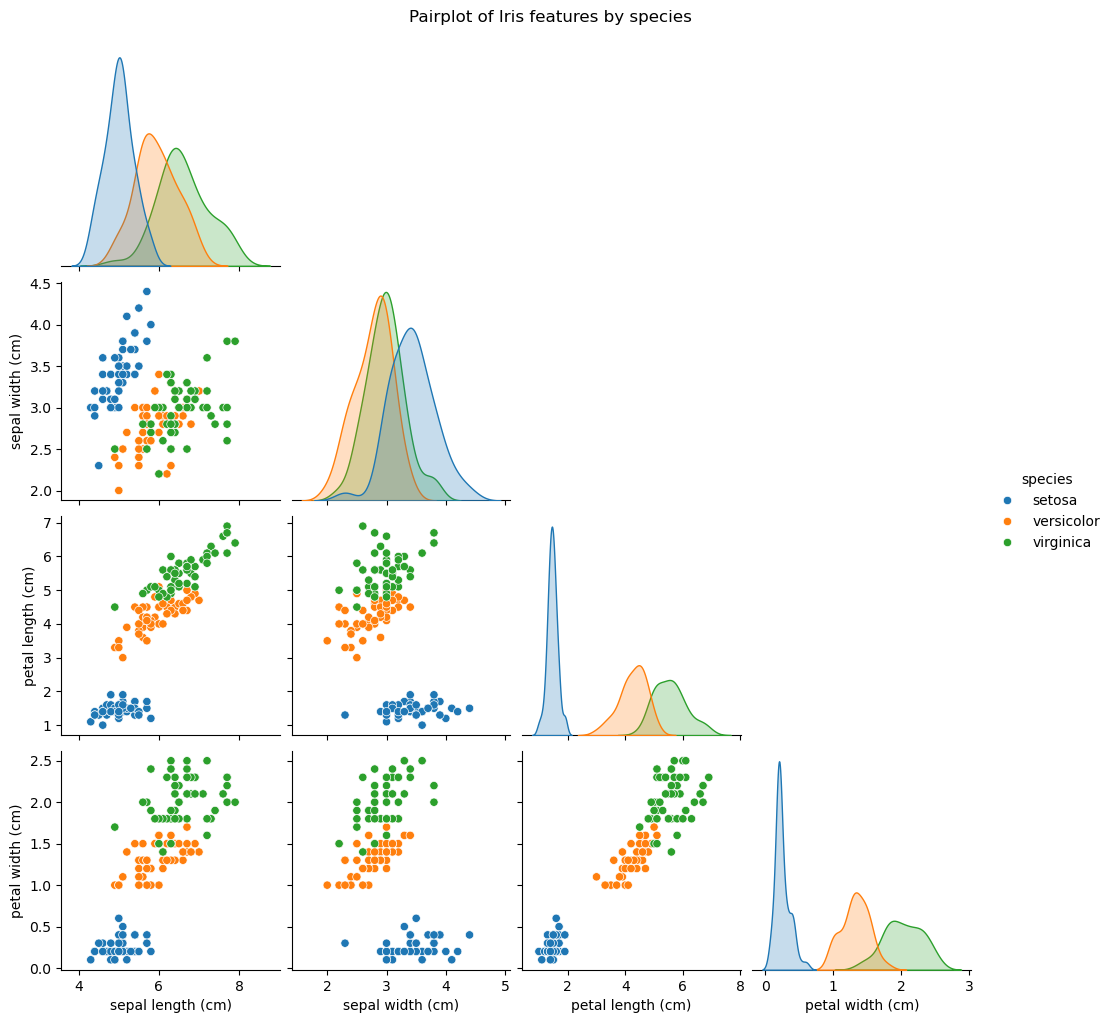

In [ ]:
sns.pairplot(df, hue="species", corner=True)
plt.suptitle("Pairplot of Iris features by species", y=1.02)
plt.show()

The pairplot shows how all features relate to each other. The results clearly separates the three species: Setosa forms its own distinct cluster, while Versicolor and Virginica show some overlap but still have noticeable differences, especially in petal size.

### Correlation matrix and heatmap (only numeric columns)

Correlation matrix:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.118129           0.873738   
sepal width (cm)           -0.118129          1.000000          -0.426028   
petal length (cm)           0.873738         -0.426028           1.000000   
petal width (cm)            0.820620         -0.362894           0.962772   

                   petal width (cm)  
sepal length (cm)          0.820620  
sepal width (cm)          -0.362894  
petal length (cm)          0.962772  
petal width (cm)           1.000000  


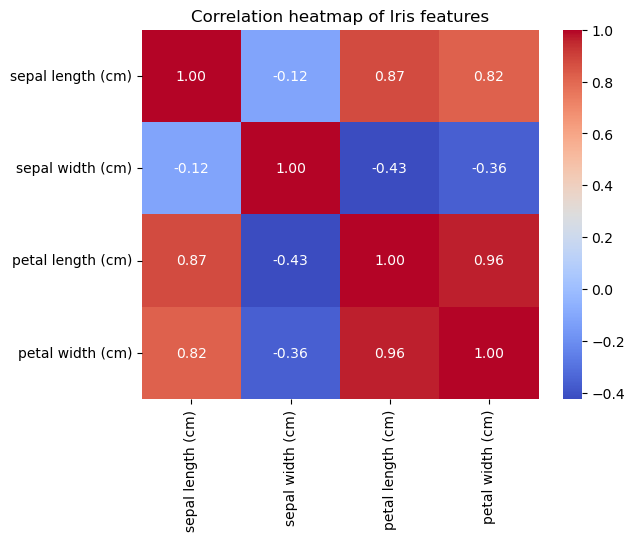

In [ ]:
corr = df[numeric_cols].corr()
print("Correlation matrix:")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap of Iris features")
plt.show()

Petal length and petal width are strongly correlated, while sepal width has weaker links to the other features. This helps show which features are most useful for classification.


## 7. Feature Engienering:
The goal of feature engineering is to extract and create relevant features, so that the model will be more generalized, and can help reduce overfitting. 
Methods that we can use in our case, are handling missing values, and scaling numerical features. Also, we can create new features from existing ones. 

As part of the process, we add the following features:
* *petal area*
* *sepal area*
* *petal-to-sepal length ratio*

The area features are calculated by multiplying the petal length and petal width, and sepal length and sepal width, respectively.

The ratio is calculated by dividing petal length by sepal length.


These new features help provide clearer differences between the species. Adding features from the original measurements helps to deepen the analysis and infer more information from the data.


In [ ]:
# petal area
df["petal_area"] = df["petal length (cm)"] * df["petal width (cm)"]

# sepal area
df["sepal_area"] = df["sepal length (cm)"] * df["sepal width (cm)"]

New engineered feature summary:
       petal_area  sepal_area  petal_sepal_length_ratio
count  149.000000  149.000000                149.000000
mean     5.767919   17.837383                  0.616325
std      4.717353    3.368472                  0.240498
min      0.110000   10.000000                  0.206897
25%      0.420000   15.660000                  0.314815
50%      5.590000   17.680000                  0.707692
75%      9.690000   20.400000                  0.810127
max     15.870000   30.020000                  0.952381


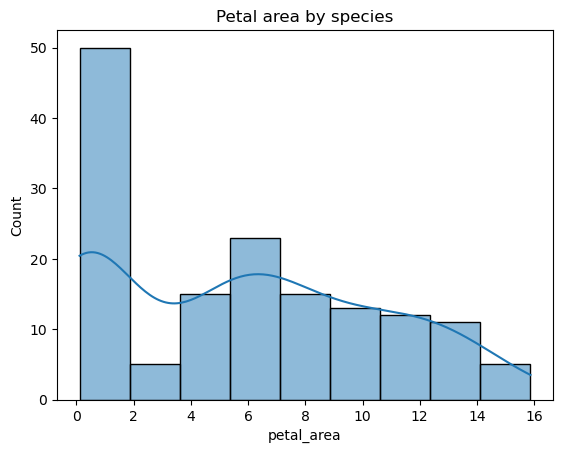

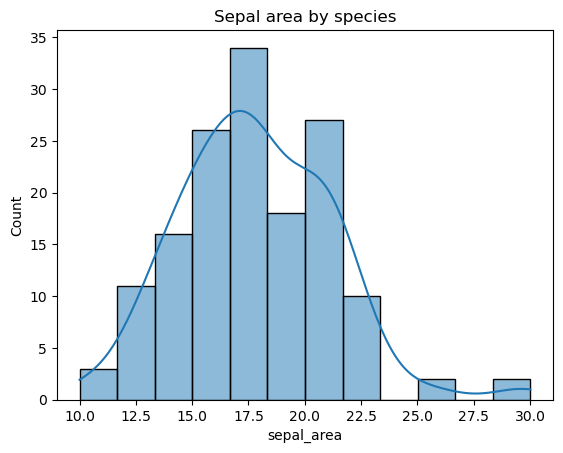

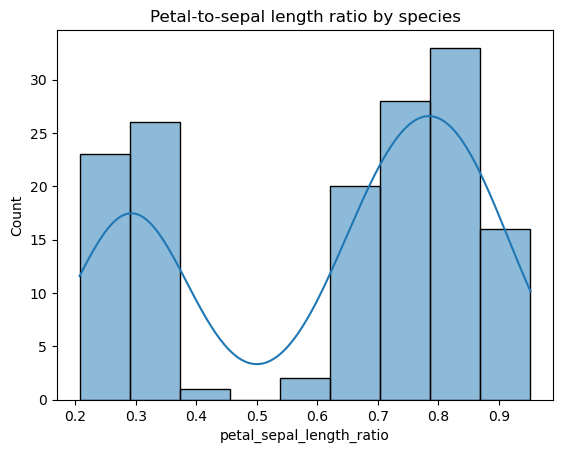

In [ ]:
# petal-to-sepal length ratio
df["petal_sepal_length_ratio"] = df["petal length (cm)"] / df["sepal length (cm)"]

print("New engineered feature summary:")
print(df[["petal_area", "sepal_area", "petal_sepal_length_ratio"]].describe())

# plot all the new features

sns.histplot(data=df, x="petal_area", kde=True)
plt.title("Petal area by species")
plt.show()

sns.histplot(data=df, x="sepal_area", kde=True)
plt.title("Sepal area by species")
plt.show()

sns.histplot(data=df, x="petal_sepal_length_ratio", kde=True)
plt.title("Petal-to-sepal length ratio by species")
plt.show()


The new features help capture more information about flower size and shape:
* The petal area distribution tells us that mos tof the flowers are small (netween 0-2 cm^2). Beyond that size, the data is more "normal" distributed.

* The sepal area distribution is very close to normal distribution.

* The petal-to-sepal length ratio distribution is very interseting: either the ratios lower than 0.5, or higher. This feature might help a future model distinguish between the species.

## 8. Target transformation
We convert the target variable into a numeric value, assigning 0 to Setosa, 1 to Versicolor, and 2 to virginica.

In [ ]:
# convert target to numeric
df["species"] = df["species"].map({"setosa": 0, "versicolor": 1, "virginica": 2})
df["species"].value_counts()


species
0    50
1    50
2    49
Name: count, dtype: int64

## 9 Feature scaling (Standardization)
In order to perform scaling, it is important to separate the data into train and test sets. This way, we preserve the imformation in the test set, which will be used to evaluate the model, while the infroamtion in the train set is used to train the model and to be applied to the test set.

In [ ]:
# split into train and test sets
X = df.drop("species", axis=1)
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit and transform on training set
X_test_scaled = scaler.transform(X_test) # transform on test set


# convert the scaled train and test sets back to Dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

We scaled the features using StandardScaler, which transforms each feature so it has a mean of 0 and a standard deviation of 1.

## 9. Summary and Conclusions

In​‍​‌‍​‍‌​‍​‌‍​‍‌ this project, we analyzed the Iris dataset by loading the data and through various methods we discerned the dataset's structure, types of features, number of samples, and simple statistics. This gave us a good idea of the data and what is included in it.

We also looked for missing values or duplicate rows to ensure that the data is clean and can be used without any problems. Though the Iris dataset is nicely arranged, these checks always need to take place in a real project.

After that, we made different plots to learn more about the features and their relationships. These graphs illustrated how the three different Iris species varied in terms of petal length, sepal width, and so on. The act of visualizing data helped us to spot the patterns more quickly and gave us a better understanding of why the dataset is so popular in machine learning demonstrations.

The preparation of data for the modeling was also done by us through the division of data into parts for training and testing. Without a doubt, this is a very necessary step as it allows the testing of the model to be done with data that hasn't been used for training.

Additionally, in the whole lab, the main points were about comprehending the data, careful preparation, and clear and logical exploration.

#### Conclusions

By working with the Iris dataset, we have come to the conclusion that it is a clean, well-balanced, and easy-to-handle data. The features demonstrate strong patterns that distinctly separate the three species thereby, the set of data is the most common one used for classification tasks in teaching.

The visualiztions made clear that some features, petal length and petal width above all, were very useful to distinguish different species. This information will definitely be of great value while training a machine-learning model as good features lead to better predictions.

Basically, the measures taken in this notebook, i.e., data loading, inspection, cleaning, and visual exploration, are an excellent groundwork for the subsequent model-building phase in our project. Not only is the work here a prerequisite for the following stages of the data-science pipeline, but it also serves as a confirmation that we understand the dataset thoroughly before moving ​‍​‌‍​‍‌​‍​‌‍​‍‌on.

# Question 3

In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# dataset
actual = [19, 30, 89, 38, 46, 77, 65, 54, 45]
predicted = [20, 26, 80, 40, 46, 74, 68, 54, 38]

df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})

# calculate evaluation metrics
mae = mean_absolute_error(df['Actual'], df['Predicted'])
mse = mean_squared_error(df['Actual'], df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(df['Actual'], df['Predicted'])

# adj R-squared
n = len(df)  # num of observations
p = 1        # num of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.3f}")
print(f"Adjusted R-squared: {adj_r2:.3f}")


Mean Absolute Error (MAE): 3.22
Mean Squared Error (MSE): 18.78
Root Mean Squared Error (RMSE): 4.33
R-squared (R²): 0.958
Adjusted R-squared: 0.952
